In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import sys 
sys.path.append('../')
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


In [2]:
from wompth.models.dqn import Transition, ReplayMemory, DQN, ScreenDims,LayerConf

/home/gorigan/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


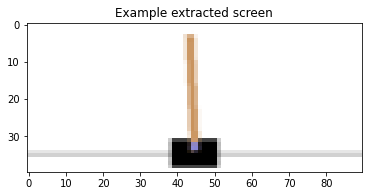

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [4]:

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
screen_dims = ScreenDims(screen_height, screen_width)
network_layout = [
    LayerConf(input=3, kernel_size=5, stride=2, batch_norm=16),
    LayerConf(input=16, kernel_size=5, stride=2, batch_norm=32),
    LayerConf(input=32, kernel_size=5, stride=2, batch_norm=32),
]

In [5]:
policy_net = DQN(layout=network_layout, screen_dims=screen_dims, outputs=n_actions)
target_net = DQN(layout=network_layout, screen_dims=screen_dims, outputs=n_actions)

Using cuda device
Using cuda device


In [6]:

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()



def plot_durations(i_episode, episode_durations):
    if (i_episode % 10) == 0: 
        plt.figure(2)
        plt.clf()
        durations_t = torch.tensor(episode_durations, dtype=torch.float)
        plt.title('Training...')
        plt.xlabel(f'Episode {i_episode}')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100 :
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  

0


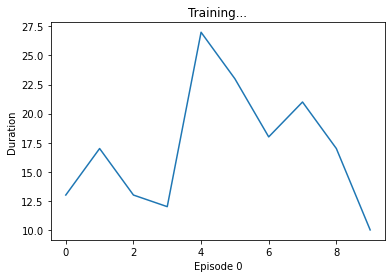

10


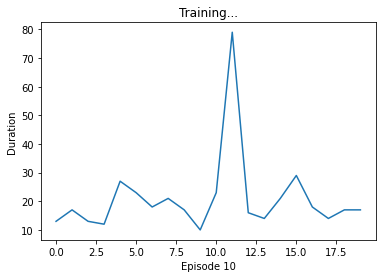

20


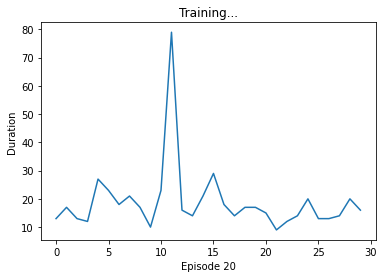

30


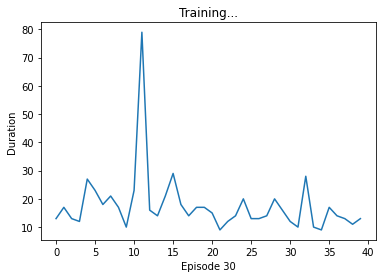

40


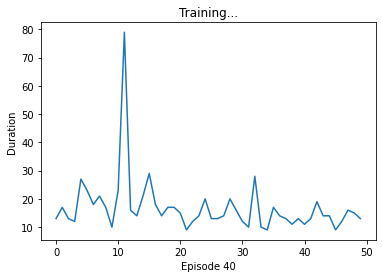

50


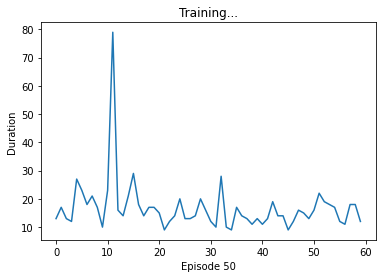

60


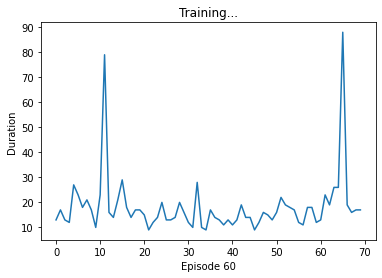

70


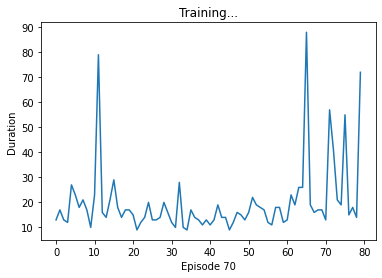

80


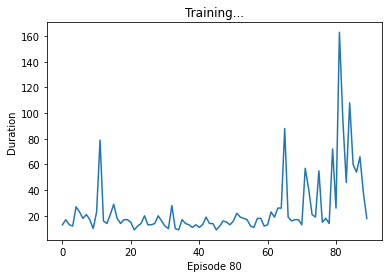

90


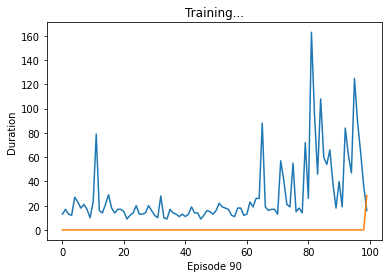

100


KeyboardInterrupt: 

In [8]:
num_episodes = 600
episodes_print = 10
episode_durations = []
for i in range(0, num_episodes, episodes_print):
    print (i)
    durations = DQN.fit_networks(policy_net,target_net, env, get_screen, num_episodes=episodes_print)
    episode_durations += durations
    plot_durations(i, episode_durations)

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

In [ ]:
plot_durations()
plt.show()

In [ ]:
# torch.save( batch_mem.memory,'../resources/tests/memory.pth')

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

        # takes in a module and applies the specified weight initialization
def zero_fill(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.fill_(0.42)
        m.bias.data.fill_(0)
policy_net2 = DQN(screen_height, screen_width, n_actions).to(device)
policy_net2.apply(zero_fill)
# policy_net2.apply(weights_init_uniform)

In [ ]:
path = '../resources/tests/memory.pth'
saved_memory = torch.load(path)
state = saved_memory[0].state

In [ ]:
r1 = policy_net2(state)
r1

In [ ]:
r1.tolist()

In [ ]:
r2 = torch.tensor([[0.06198882311582565, 0.14884909987449646]]).to('cuda')
r2

In [ ]:
torch.allclose(r1, r2, atol=1e-8)

In [ ]:
policy_net(state)